In [7]:
# Walmart Stores sales Dataset -> https://www.kaggle.com/datasets/rutuspatel/walmart-dataset-retail

# Predicting Walmart Store Sales Using Exogenous Variables and Linear Regression



This dataset contains historical sales data for different Walmart stores. Each row corresponds to a specific store's weekly sales data. The columns in the dataset are as follows:

- `Store`: The store number.
- `Date`: The week of sales. The date is in the format DD-MM-YYYY.
- `Weekly_Sales`: Sales for the given store in the specified week.
- `Holiday_Flag`: A binary flag indicating whether the week is a special holiday week (1 – Holiday week, 0 – Non-holiday week).
- `Temperature`: The temperature on the day of sale.
- `Fuel_Price`: The cost of fuel in the region.
- `CPI`: The prevailing consumer price index.
- `Unemployment`: The prevailing unemployment rate.

In [8]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/data/Walmart_Store_sales.csv')

# Display the first few rows of the dataset
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


Lets build a predictive model to forecast a store's sales based on several variables: whether it's a holiday, the temperature, fuel price, CPI, unemployment, and past store sales. This is a time series forecasting problem.

A common method for this kind of problem is ARIMA, but since we also have additional variables (exogenous variables) we will try to use SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables).

However, before we can build a model, we should first preprocess the data. For example, we need to ensure the date is in the correct format and sort the data by date. We also need to ensure there are no missing values in the data.

Let's start with the data preprocessing. We will first convert the date to the correct format and sort the data. Then We will check for missing values.

In [9]:
# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# Sort the data by 'Date'
data.sort_values('Date', inplace=True)

# Reset the index
data.reset_index(drop=True, inplace=True)

# Check for missing values
missing_values = data.isnull().sum()

missing_values

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

The dataset does not contain any missing values, which is great because we don't have to handle imputations.

Now, before we proceed with the model development, it would be beneficial to conduct some exploratory data analysis (EDA). This will help us better understand the relationships between different variables and their impact on weekly sales.

Let's create some plots to visualize these relationships. I'll generate the following plots:

- `Weekly sales over time.`
- `Weekly sales grouped by whether it was a holiday or not.`
- `Weekly sales in relation to temperature, fuel price, CPI, and unemployment.`

This should provide us with a preliminary understanding of the patterns and correlations within our data.

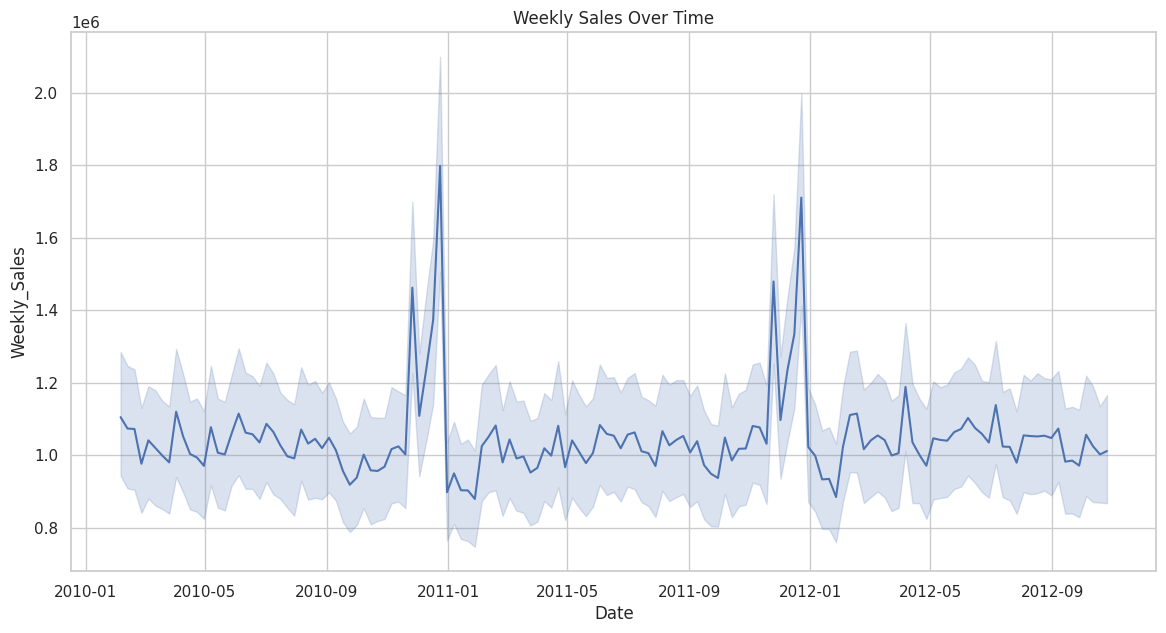

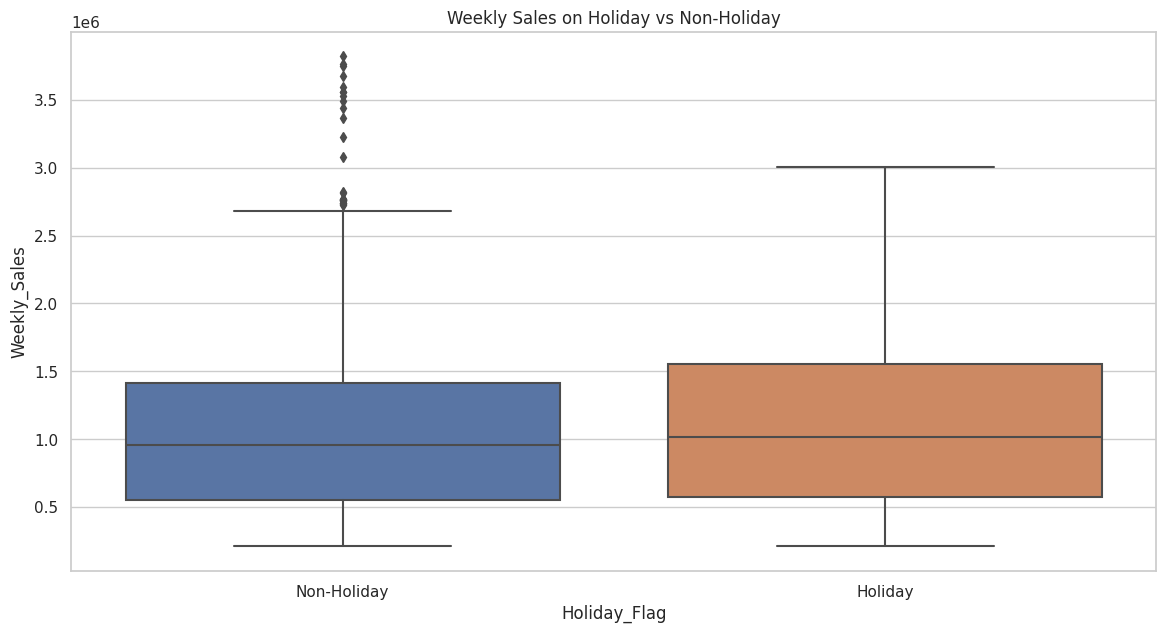

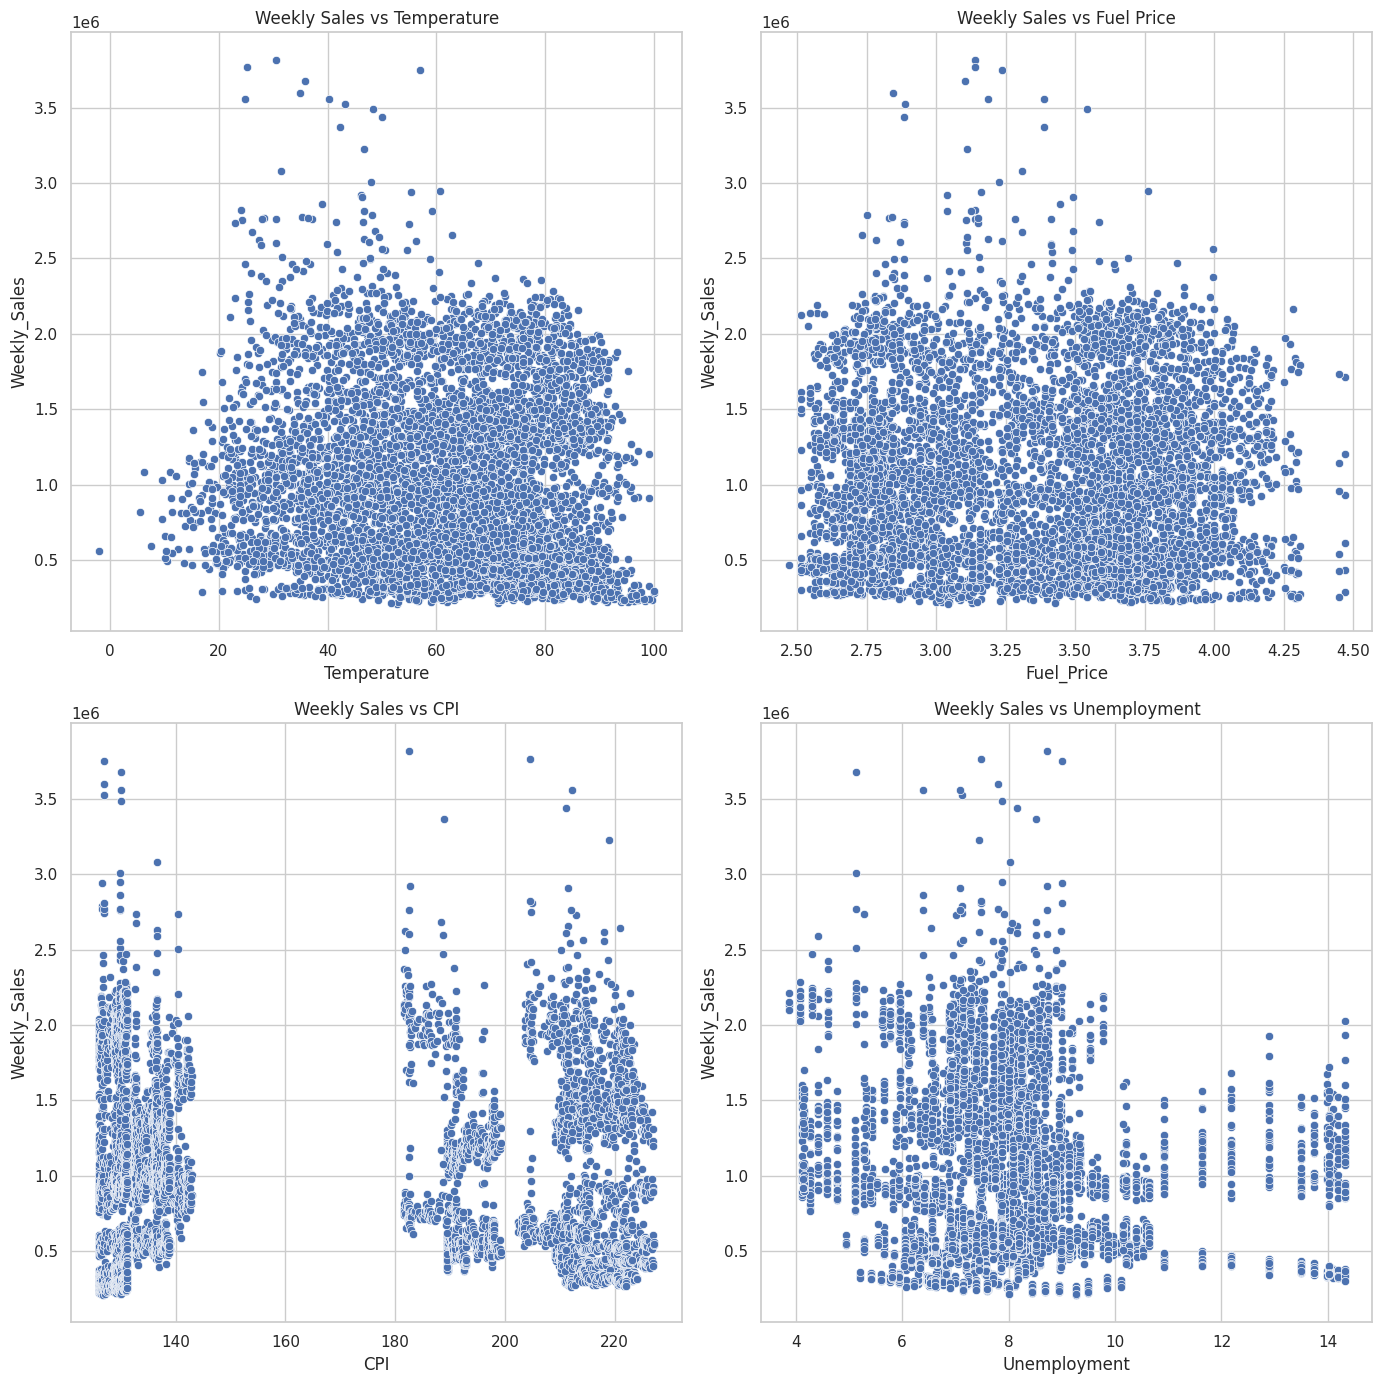

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plot
sns.set(style="whitegrid")

# Plot weekly sales over time
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='Weekly_Sales', data=data)
plt.title('Weekly Sales Over Time')
plt.show()

# Plot weekly sales grouped by whether it was a holiday or not
plt.figure(figsize=(14, 7))
sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=data)
plt.title('Weekly Sales on Holiday vs Non-Holiday')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.show()

# Plot weekly sales in relation to temperature, fuel price, CPI, and unemployment
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 14))

sns.scatterplot(x='Temperature', y='Weekly_Sales', data=data, ax=ax1)
ax1.set_title('Weekly Sales vs Temperature')

sns.scatterplot(x='Fuel_Price', y='Weekly_Sales', data=data, ax=ax2)
ax2.set_title('Weekly Sales vs Fuel Price')

sns.scatterplot(x='CPI', y='Weekly_Sales', data=data, ax=ax3)
ax3.set_title('Weekly Sales vs CPI')

sns.scatterplot(x='Unemployment', y='Weekly_Sales', data=data, ax=ax4)
ax4.set_title('Weekly Sales vs Unemployment')

plt.tight_layout()
plt.show()

The plots give us some insight into the data:

- `Weekly Sales Over Time`: The line plot shows that sales have some seasonality, with peaks around certain periods of the year. There also seem to be some outliers with extremely high sales.

- `Weekly Sales on Holiday vs Non-Holiday`: The box plot shows that there are higher sales during holidays compared to non-holidays. This is consistent with what we might expect, as holidays often lead to increased consumer spending.

- `Weekly Sales vs Temperature/Fuel Price/CPI/Unemployment`: The scatter plots show that there's no clear linear relationship between weekly sales and temperature, fuel price, CPI, or unemployment. This suggests that these variables may not be strong predictors for weekly sales on their own.

Now, let's move onto building the prediction models to forecast demand. To start, I'll build a simple linear regression model with the variables we mentioned: Holiday_Flag, Temperature, Fuel_Price, CPI, Unemployment, and lagged Weekly_Sales (which represents past store sales).

For the lagged Weekly_Sales, We will create a new column Prev_Weekly_Sales that shifts the Weekly_Sales down by one period. This means for each record, we'll have the sales of the previous week. This is a common technique when working with time series data, because it allows the model to use the sales value from the previous time step to predict the sales value at the current time step.

Before building the model, I'll split the data into training and testing sets. The model will be trained on the training set and evaluated on the testing set.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

# Create the lagged Weekly_Sales column
data['Prev_Weekly_Sales'] = data['Weekly_Sales'].shift()
data.dropna(inplace=True)  # drop the first row which has now become NaN

# Define the feature columns and the target column
feature_cols = ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Prev_Weekly_Sales']
target_col = 'Weekly_Sales'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data[feature_cols], data[target_col], test_size=0.2, random_state=42)

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = sqrt(mean_squared_error(y_test, y_pred))

rmse

532957.8542719887

The root mean squared error (RMSE) of the linear regression model on the test set is approximately $532,957.85.

RMSE is a common measure used to evaluate the accuracy of a regression model. It represents the standard deviation of the residuals (prediction errors). In this case, it means that the average prediction error of our model is about $532,957.85.

Given the magnitude of weekly sales, this error might be considered high. The model's performance could potentially be improved by incorporating more sophisticated techniques like time series analysis or by fine-tuning the model's parameters.

For the next time, I want to find a dataset that has data for individual products. I think the given temperature could be predictive for certain product categories and CPI input data.